# Análise - Globo Esporte Olimpiadas

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
module_path2 = os.path.abspath(os.path.join('../../AxolotlDataScience'))

if module_path not in sys.path:
    sys.path.append(module_path)
    sys.path.append(module_path2)

from DataManagement import DataHandler as dataManipulation
from DataVisualization import TypeOfAccessBarChart
from Graphics import MultipleColumnsBarChartByClass
from Graphics import SingleColumnBarChartByClass
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

dt = dataManipulation.DataHandler('../input_data/ge_mes_olimpiadas.csv')
data_frame = dt.get_data_frame()

Visão Geral
=============

Antes de mais nada precisamos ter uma visão geral dos dados para nos dar uma ideia geral dos dados e nos dar base para comparações no decorrer do kernel, para isso irei coletar informações gerais de alguns aspectos da base de dados. Sendo elas:

+ Média de páginas visitadas por acessos
+ Média de acesso por dia
+ Média de tempo gasto em uma página
+ Média de tempo gasto por acesso
+ Média de tempo gasto por dia
+ Tempo médio gasto nas páginas de esporte em geral
+ Tempo médio gasto nas páginas de modalidades olímpicas
+ Quantidade de assinantes
+ Quantidade de jogadores Cartola
+ Quantidade de assinantes Cartola

╒═════════════════════════════════════╤════════════╕
│ Tipo                                │      Média │
╞═════════════════════════════════════╪════════════╡
│ páginas por visita                  │    2.85815 │
├─────────────────────────────────────┼────────────┤
│ visitas por dia                     │    1.61505 │
├─────────────────────────────────────┼────────────┤
│ Média do tempo gasto por página     │  205.025   │
├─────────────────────────────────────┼────────────┤
│ Média do tempo gasto por visita     │  628.435   │
├─────────────────────────────────────┼────────────┤
│ Média do tempo gasto por dia        │ 1018.31    │
├─────────────────────────────────────┼────────────┤
│ Média do tempo gasto em pagina home │ 2440.22    │
╘═════════════════════════════════════╧════════════╛


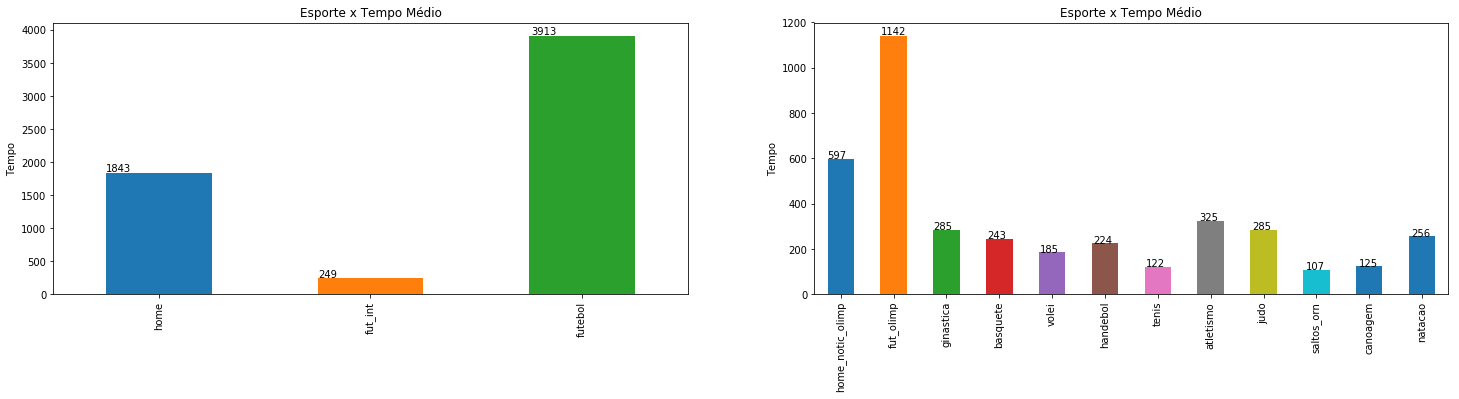

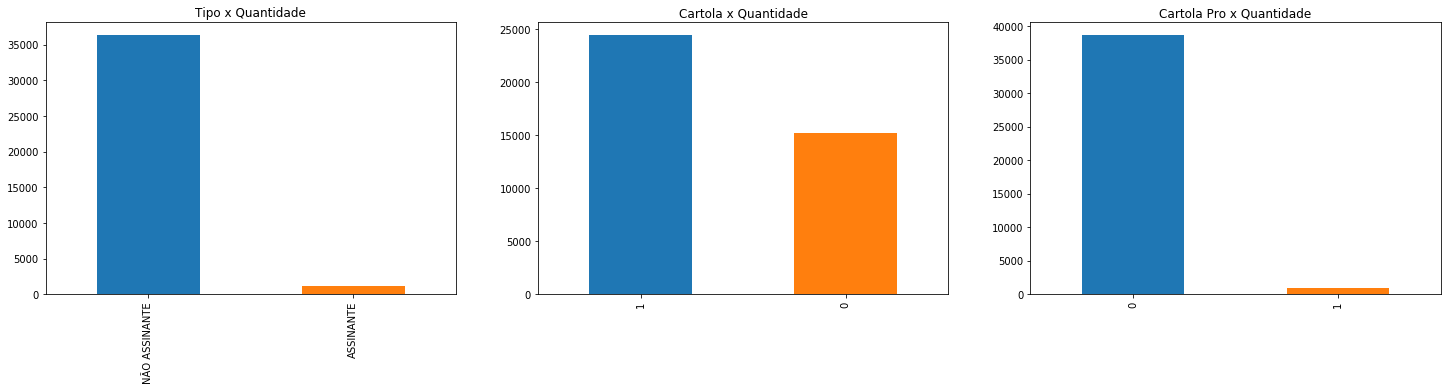

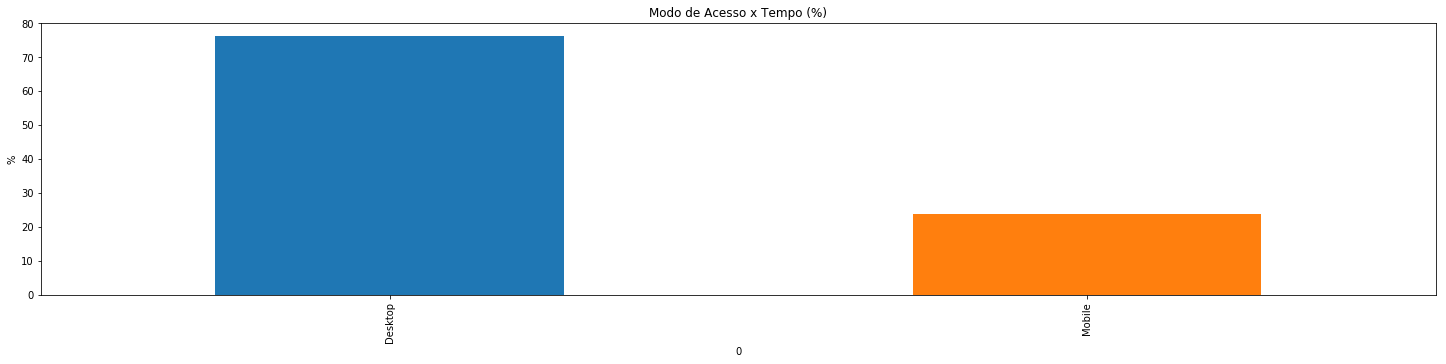

In [29]:
df_visit = data_frame[data_frame['visitas'] > 0]
df_days = data_frame[data_frame['dias'] > 0]
df_pviews = data_frame[data_frame['pviews'] > 0]

access_info = {}

access_info['páginas por visita'] = (df_visit['pviews']/df_visit['visitas']).mean()
access_info['visitas por dia'] = (df_days['visitas']/df_days['dias']).mean()
access_info['Média do tempo gasto por página'] = (df_pviews['tempo_total']/df_pviews['pviews']).mean()
access_info['Média do tempo gasto por visita'] = (df_visit['tempo_total']/df_visit['visitas']).mean()
access_info['Média do tempo gasto por dia'] = (df_days['tempo_total']/df_days['dias']).mean()
access_info['Média do tempo gasto em pagina home'] = ((data_frame['home_notic_olimp'] + data_frame['home'])).mean()

df_access = pd.DataFrame(list(access_info.items()))

time_spent_in_sports = data_frame[['home', 'fut_int', 'futebol']].mean()
time_spent_in_olympics = data_frame[['home_notic_olimp', 'fut_olimp', 'ginastica', 'basquete', 'volei', 'handebol', 'tenis', 'atletismo', 'judo', 'saltos_orn', 'canoagem', 'natacao']].mean()

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = time_spent_in_sports.plot(kind='bar', x=0, y=1, figsize=(25, 5), ax=axes[0], title='Esporte x Tempo Médio')
ax.set_ylabel("Tempo")
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax = time_spent_in_olympics.plot(kind='bar', x=0, y=1, figsize=(25, 5), ax=axes[1], title='Esporte x Tempo Médio')
ax.set_ylabel("Tempo")
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

fig, axes = plt.subplots(nrows=1, ncols=3)
data_frame['tipo'].value_counts().plot(kind='bar', figsize=(25, 5), ax=axes[0], title='Tipo x Quantidade')
data_frame['cartola'].value_counts().plot(kind='bar', figsize=(25, 5), ax=axes[1], title='Cartola x Quantidade')
data_frame['cartola_pro'].value_counts().plot(kind='bar', figsize=(25, 5), ax=axes[2], title='Cartola Pro x Quantidade')

time_spent_percentage_dict= {}
total_time_spent = data_frame['tempo_total'].sum()
time_spent_percentage_dict['Desktop'] = 100 * data_frame['tempo_total_desktop'].sum() / total_time_spent
time_spent_percentage_dict['Mobile'] = 100 * data_frame['tempo_total_mobile'].sum() / total_time_spent

df_time = pd.DataFrame(list(time_spent_percentage_dict.items()))

ax = df_time.plot(kind='bar', x=0, y=1, figsize=(25, 5), title='Modo de Acesso x Tempo (%)', legend=False)
ax.set_ylabel("%")

print(tabulate(df_access, tablefmt='fancy_grid', showindex=False, headers=['Tipo', 'Média']))

Com isso podemos tirar algumas conclusões:

+ Os usuários passam um tempo significativo nas páginas de home, o que pode ser devido a 2 fatores:
  + A página de home possui todas as infomações que o usuário precisa
  + O usuário demora a achar a informação desejada na home
+ O cartola possui um público significativo entre os usuários
+ O futebol nacional continuou sendo o centro das atenções, mesmo em período de olimpiadas
+ Os usuários de desktop são a maioria em relação a tempo de uso no globo esporte

Modo de Acesso
===============

Na seção anterior observamos o padrão de visitas de página, tempo gasto nas páginas, entre outras métricas em relação a toda a base de dados, porém temos 2 fontes de acesso, desktop e mobile, nesta seção iremos explorar a diferença da conexão entre essas 2 formas de acesso, e compara-las com a média geral.

Primeiramente precisamos identificar quem é o usuário desktop e o usuário mobile. Afinal queremos entender como os usuários de cada um deles se comportam, uma vez que um usuário não utiliza, ou utiliza muito pouco o desktop ele só irá causar ruído quando analisarmos os dados dos usuários de desktop, pensando nisto criei 3 grupos de usuários:

+ Mobile - utilizam o mobile 70% do tempo ou mais
+ Desktop - utilizam o desktop 70 % do tempo ou mais
+ Both - utilizam o Mobile e Desktop em tempo similar

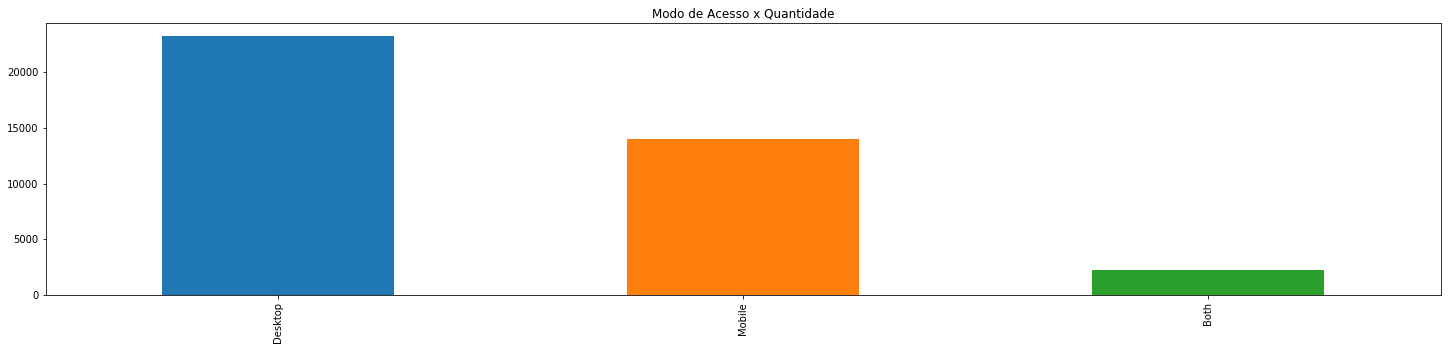

In [4]:
dt.time_to_percentage(['tempo_total_desktop', 'tempo_total_mobile'])\
  .define_desktop_and_cellphone_users()
    
time_spent_percentage_dict = {}

total_time_spent = data_frame['tempo_total'].sum()   
data_frame['device_preference'].value_counts().plot(kind='bar', figsize=(25, 5), title='Modo de Acesso x Quantidade')

Mobile
---------

╒═════════════════════════════════════╤════════════╤══════════════════╕
│ Tipo                                │      Média │   Comparação (%) │
╞═════════════════════════════════════╪════════════╪══════════════════╡
│ páginas por visita                  │    2.0514  │        -28.2264  │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ visitas por dia                     │    1.59335 │         -1.34378 │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ Média do tempo gasto por página     │  132.639   │        -35.3062  │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ Média do tempo gasto por visita     │  300.574   │        -52.171   │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ Média do tempo gasto por dia        │  513.708   │        -49.5531  │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ Média do tempo gasto em página home │ 1484.29    │        -39.

Text(0,0.5,'%')

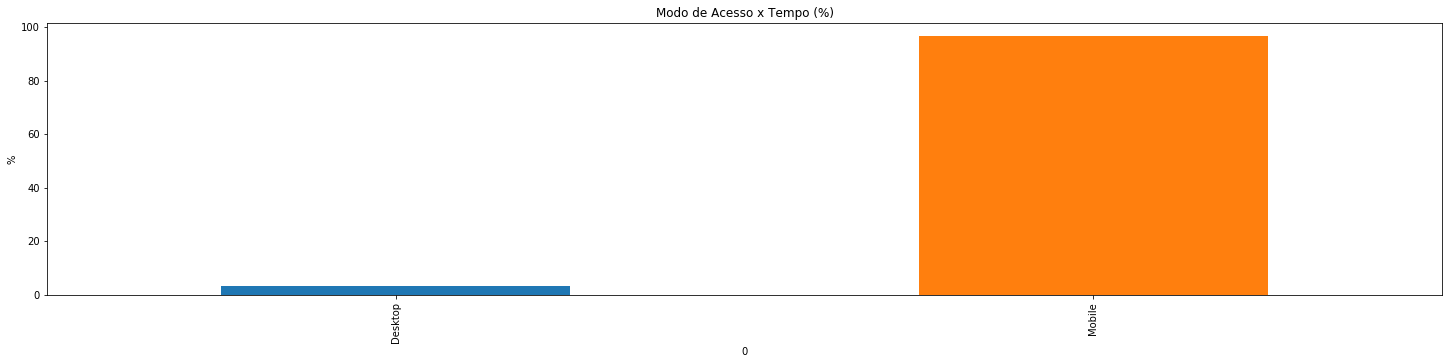

In [5]:
df_mobile = data_frame[data_frame['device_preference'].isin(['Mobile'])]

df_visit = df_mobile[df_mobile['visitas_mobile'] > 0]
df_days = df_mobile[df_mobile['dias_mobile'] > 0]
df_pviews = df_mobile[df_mobile['pviews_mobile'] > 0]

access_info_mobile = {}
access_info_mobile['páginas por visita'] = (df_visit['pviews_mobile']/df_visit['visitas_mobile']).mean()
access_info_mobile['visitas por dia'] = (df_days['visitas_mobile']/df_days['dias_mobile']).mean()
access_info_mobile['Média do tempo gasto por página'] = (df_pviews['tempo_total_mobile']/df_pviews['pviews_mobile']).mean()
access_info_mobile['Média do tempo gasto por visita'] = (df_visit['tempo_total_mobile']/df_visit['visitas_mobile']).mean()
access_info_mobile['Média do tempo gasto por dia'] = (df_days['tempo_total_mobile']/df_days['dias_mobile']).mean()
access_info_mobile['Média do tempo gasto em página home'] = ((df_mobile['home_notic_olimp'] + df_mobile['home'])).mean()

df_access_mobile = pd.DataFrame(list(access_info_mobile.items()))

df_access_mobile['Comparação'] = ((df_access_mobile[1] - df_access[1]) / df_access[1]) * 100

print(tabulate(df_access_mobile, tablefmt='fancy_grid', showindex=False, headers=['Tipo', 'Média', 'Comparação (%)']))

total_time_spent = df_mobile['tempo_total'].sum()
time_spent_percentage_dict['Desktop'] = 100 * df_mobile['tempo_total_desktop'].sum() / total_time_spent
time_spent_percentage_dict['Mobile'] = 100 * df_mobile['tempo_total_mobile'].sum() / total_time_spent

df_time = pd.DataFrame(list(time_spent_percentage_dict.items()))

ax = df_time.plot(kind='bar', x=0, y=1, figsize=(25, 5), title='Modo de Acesso x Tempo (%)', legend=False)
ax.set_ylabel("%")

Desktop
--------

╒═════════════════════════════════════╤════════════╤══════════════════╕
│ Tipo                                │      Média │   Comparação (%) │
╞═════════════════════════════════════╪════════════╪══════════════════╡
│ páginas por visita                  │    3.52523 │         23.3397  │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ visitas por dia                     │    1.56883 │         -2.86168 │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ Média do tempo gasto por página     │  271.359   │         32.3539  │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ Média do tempo gasto por visita     │  928.157   │         47.6934  │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ Média do tempo gasto por dia        │ 1428.61    │         40.2918  │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ Média do tempo gasto em página home │ 2964.34    │         21.

Text(0,0.5,'%')

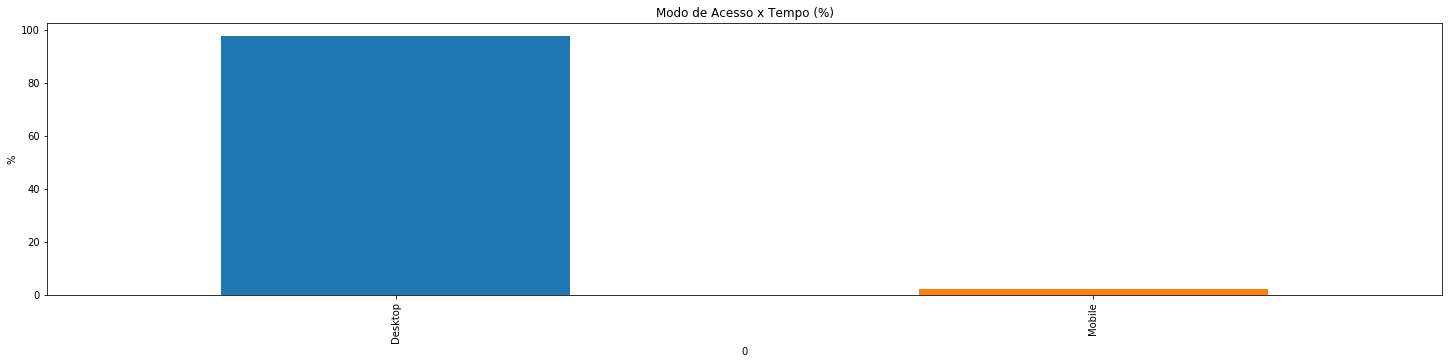

In [6]:
df_desktop = data_frame[data_frame['device_preference'].isin(['Desktop'])]

df_visit = df_desktop[df_desktop['visitas_desktop'] > 0]
df_days = df_desktop[df_desktop['dias_desktop'] > 0]
df_pviews = df_desktop[df_desktop['pviews_desktop'] > 0]

access_info_desktop = {}
access_info_desktop['páginas por visita'] = (df_visit['pviews_desktop']/df_visit['visitas_desktop']).mean()
access_info_desktop['visitas por dia'] = (df_days['visitas_desktop']/df_days['dias_desktop']).mean()
access_info_desktop['Média do tempo gasto por página'] = (df_pviews['tempo_total_desktop']/df_pviews['pviews_desktop']).mean()
access_info_desktop['Média do tempo gasto por visita'] = (df_visit['tempo_total_desktop']/df_visit['visitas_desktop']).mean()
access_info_desktop['Média do tempo gasto por dia'] = (df_days['tempo_total_desktop']/df_days['dias_desktop']).mean()
access_info_desktop['Média do tempo gasto em página home'] = ((df_desktop['home_notic_olimp'] + df_desktop['home'])).mean()

df_access_desktop = pd.DataFrame(list(access_info_desktop.items()))

df_access_desktop['Comparação'] = ((df_access_desktop[1] - df_access[1]) / df_access[1]) * 100

print(tabulate(df_access_desktop, tablefmt='fancy_grid', showindex=False, headers=['Tipo', 'Média', 'Comparação (%)']))

total_time_spent = df_desktop['tempo_total'].sum()
time_spent_percentage_dict['Desktop'] = 100 * df_desktop['tempo_total_desktop'].sum() / total_time_spent
time_spent_percentage_dict['Mobile'] = 100 * df_desktop['tempo_total_mobile'].sum() / total_time_spent

df_time = pd.DataFrame(list(time_spent_percentage_dict.items()))

ax = df_time.plot(kind='bar', x=0, y=1, figsize=(25, 5), title='Modo de Acesso x Tempo (%)', legend=False)
ax.set_ylabel("%")

Ambos
------

╒═════════════════════════════════════╤════════════╤══════════════════╕
│ Tipo                                │      Média │   Comparação (%) │
╞═════════════════════════════════════╪════════════╪══════════════════╡
│ páginas por visita                  │    2.04394 │        -28.4871  │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ visitas por dia                     │    1.59539 │         -1.21772 │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ Média do tempo gasto por página     │  125.995   │        -38.5468  │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ Média do tempo gasto por visita     │  287.832   │        -54.1986  │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ Média do tempo gasto por dia        │  512.526   │        -49.6692  │
├─────────────────────────────────────┼────────────┼──────────────────┤
│ Média do tempo gasto em página home │ 2980.61    │         22.

Text(0,0.5,'%')

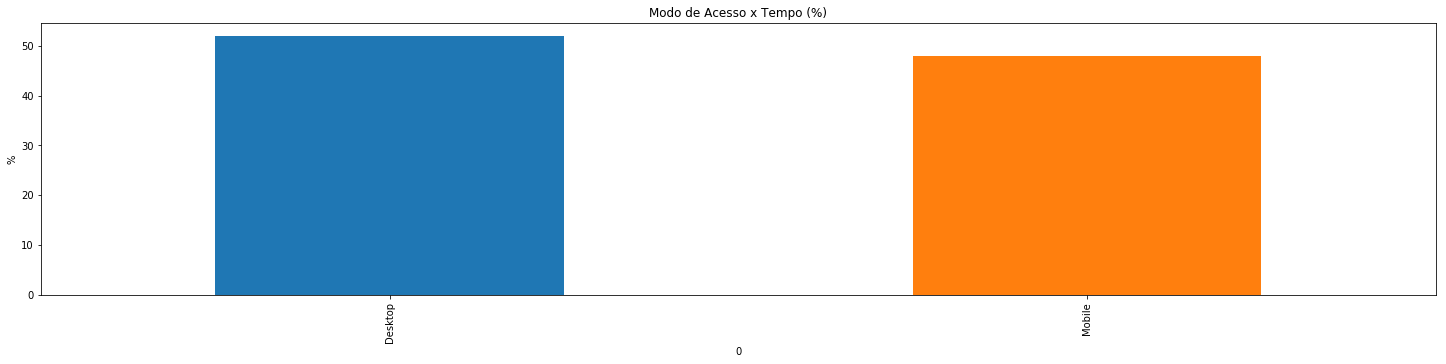

In [7]:
df_mobile = data_frame[data_frame['device_preference'].isin(['Both'])]

df_visit = df_mobile[df_mobile['visitas_mobile'] > 0]
df_days = df_mobile[df_mobile['dias_mobile'] > 0]
df_pviews = df_mobile[df_mobile['pviews_mobile'] > 0]

access_info_mobile = {}
access_info_mobile['páginas por visita'] = (df_visit['pviews_mobile']/df_visit['visitas_mobile']).mean()
access_info_mobile['visitas por dia'] = (df_days['visitas_mobile']/df_days['dias_mobile']).mean()
access_info_mobile['Média do tempo gasto por página'] = (df_pviews['tempo_total_mobile']/df_pviews['pviews_mobile']).mean()
access_info_mobile['Média do tempo gasto por visita'] = (df_visit['tempo_total_mobile']/df_visit['visitas_mobile']).mean()
access_info_mobile['Média do tempo gasto por dia'] = (df_days['tempo_total_mobile']/df_days['dias_mobile']).mean()
access_info_mobile['Média do tempo gasto em página home'] = ((df_mobile['home_notic_olimp'] + df_mobile['home'])).mean()

df_access_mobile = pd.DataFrame(list(access_info_mobile.items()))

df_access_mobile['Comparação'] = ((df_access_mobile[1] - df_access[1]) / df_access[1]) * 100

print(tabulate(df_access_mobile, tablefmt='fancy_grid', showindex=False, headers=['Tipo', 'Média', 'Comparação (%)']))

total_time_spent = df_mobile['tempo_total'].sum()
time_spent_percentage_dict['Desktop'] = 100 * df_mobile['tempo_total_desktop'].sum() / total_time_spent
time_spent_percentage_dict['Mobile'] = 100 * df_mobile['tempo_total_mobile'].sum() / total_time_spent

df_time = pd.DataFrame(list(time_spent_percentage_dict.items()))

ax = df_time.plot(kind='bar', x=0, y=1, figsize=(25, 5), title='Modo de Acesso x Tempo (%)', legend=False)
ax.set_ylabel("%")

Desktop x Mobile
-----------------

Podemos notar algumas coisas interessantes, o usuário do Desktop utiliza o globo esporte por mais tempo, como visto anteriormente, e este usuário realmente é o mis engajado com o site, como podemos ver pelas tabelas acima.

O interessante é quando analisamos o tempo que cada usuário gasta na página de home, o usuário Mobile fica 40% a menos que a média nas páginas de home, o que indica que ele foi direto para as notícias por outro meio, redes sociais, ferramentas de pesquisa, ou seja, não utilizou a home para achar a notícia desejada.

Já nos usuários que utilizam ambas tecnologias podemos ver que ele segue o padrão do usuário mobile, exceto quanto a home, já que eles a utilizam 22% a mais que a média normal, provavelmente estes acessos se dêem de um desktop, visto que, mesmo que por pouco, ainda é o meio preferido desse tipo de usuário.

Usuários
=========

Agora precisamos entender quem são os usuários do globo esporte em geral, para isso temos algumas informações interessantes na base de dados, sendo elas o *sexo*, a *uf*, e a *idade* de cada usuário.

Idade
------

Primeiro vamos analisar as idades dos usuários que utilizam o globo esporte, após isto veremos se a idade do usuário influência na forma de acesso, nos interesses, no uso do cartola e na assinatura ou do cartola ou da globo em si.

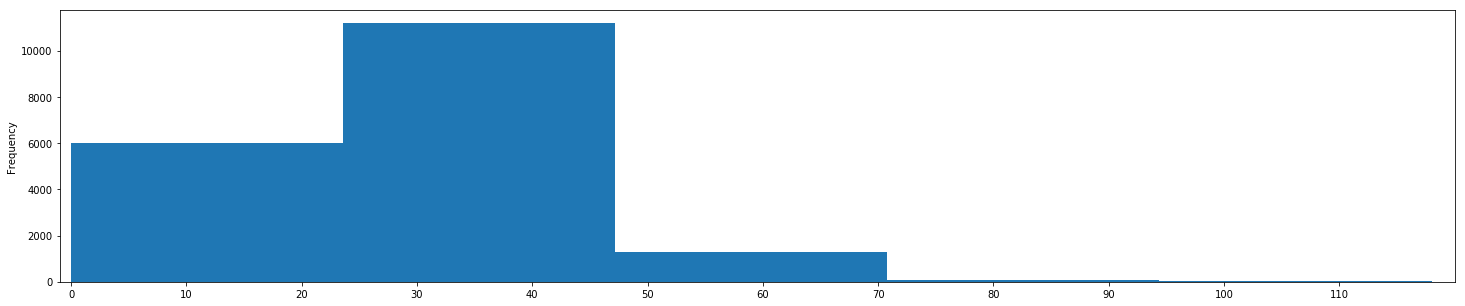

In [8]:
x_ticks = list(range(0, 120, 10))
ax = data_frame['idade'].plot(kind='hist', xlim=[-1, 120], figsize=(25, 5), xticks=x_ticks)
plt.show()

Podemos observar que a maioria dos usuários se encontra entre 23 e 48 anos, seguidos pelos que tem até 23 anos e por fim os que tem mais de 48 anos.

Por estes intervalos serem grandes englobarem diferentes gerações farei subdivisões entre os grupos mais frequentes, de forma a diminuir a granularidade nesses grupos para as próximas analises.

#### Intervalos

+ 0 - [0, 13]
+ 1 - [13, 23]
+ 2 - [23, 35]
+ 3 - [35, 48]
+ 4 - 48+

In [9]:
age_interval = [-np.inf, 13, 23, 35, 48, np.inf]

dt.discretize_column('idade', age_interval)

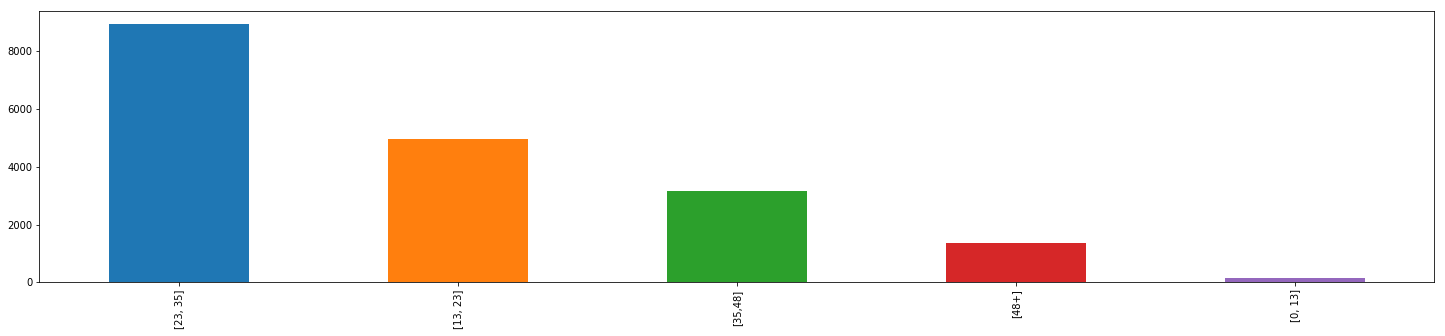

In [10]:
data_frame['idade'] = data_frame['idade'].map({0: '[0, 13]', 1: '[13, 23]', 2: '[23, 35]', 3:'[35,48]', 4:'[48+]'})

idade_without_null = data_frame.loc[data_frame['idade'].notnull()]

data_frame['idade'].value_counts().plot(kind='bar', figsize=(25, 5))

Com a nova podemos observar que a maioria dos usuários se tem de 13 a 35 anos, ao contrário do que se pensava anteriormente, pois o grupo 0 influênciou muito a primeira parte do histograma, já que o público infantil não acessa tanto o globo esporte. 

#### **Acesso**

Agora, com estes 5 grupos definidos, podemos nos fazer a seguinte pergunta:

**A idade influência o modo de acesso (mobile, desktop) ao globo esporte?**

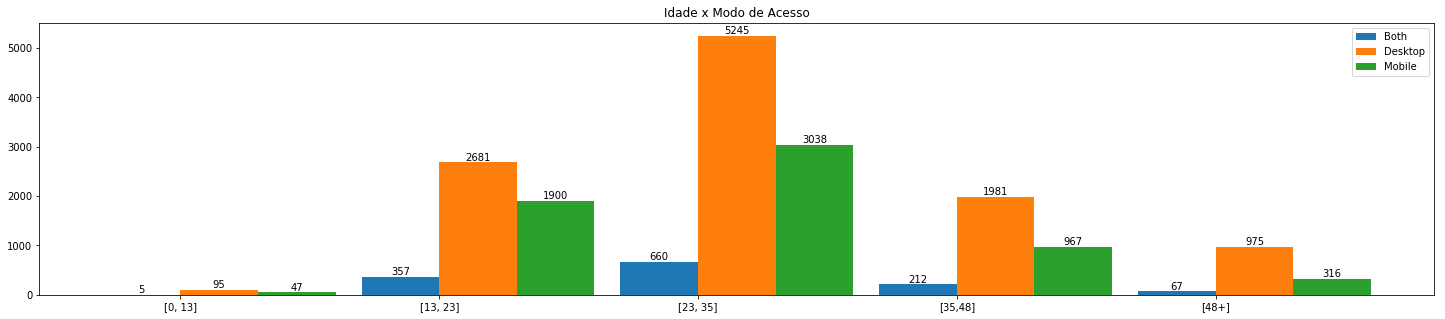

In [11]:

bar_chart = SingleColumnBarChartByClass.SingleColumnBarChartByClass(plt, rows=1, columns=1, x_size=25, y_size=5)

bar_chart.set_attribute_values(idade_without_null.idade) \
         .set_class_values(idade_without_null.device_preference) \
         .plot_chart('Idade x Modo de Acesso', 0, 0)

Com isto podemos notar que apesar dos usuários de desktop serem maioria, a quantidade de usuários mobile já é grande, e se observarmos o gráfico acima veremos que quanto mais jovem o grupo mais estes utilizam o mobile como fonte principal de acesso.

#### **Interesses**

Agora em relação aos interesses dos usuários uma série de perguntas surgem:

+ Qual a faixa etária tem mais chances de:
  + ser um assinante?
  + participar do cartola?
  + possuir cartola-pro?
+ Qual esporte olímpico é o preferido de cada faixa etária?
+ Qual o interesse em futebol de cada faixa etária?
+ Quanto tempo cada faixa etária passa na home?

#### Planos


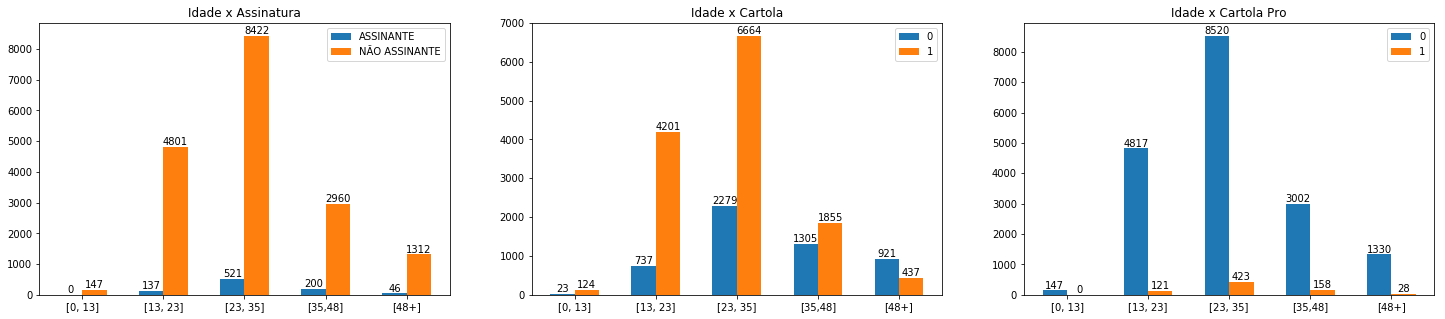

In [12]:
bar_chart = SingleColumnBarChartByClass.SingleColumnBarChartByClass(plt, rows=1, columns=3, x_size=25, y_size=5)

bar_chart.set_attribute_values(idade_without_null.idade) \
         .set_class_values(idade_without_null.tipo) \
         .plot_chart('Idade x Assinatura', 0, 0)
        
bar_chart.set_attribute_values(idade_without_null.idade) \
         .set_class_values(idade_without_null.cartola) \
         .plot_chart('Idade x Cartola', 0, 1)
        
bar_chart.set_attribute_values(idade_without_null.idade) \
         .set_class_values(idade_without_null.cartola_pro) \
         .plot_chart('Idade x Cartola Pro', 0, 2)

Podemos notar algumas coisas interessantes nesses gráficos.

* Praticamente todo o público infantil do globo esporte possui uma conta no cartola.
* O grupo 1 é percentualmente o que mais tem conta no cartola.
* O grupo 3 é percentualmente o que mais tem cartola pro.
* O grupo 4 não é tão interessado no cartola quanto os demais.

#### Olímpiadas

Para analisar os outros 2 pontos iremos analisar qual o tempo médio que cada faixa etária gastou com as olímpiadas e futebol durante o mês, e comparar com a média geral da base de dados para assim sabermos o quanto determinada faixa etária se engajou com cada esporte

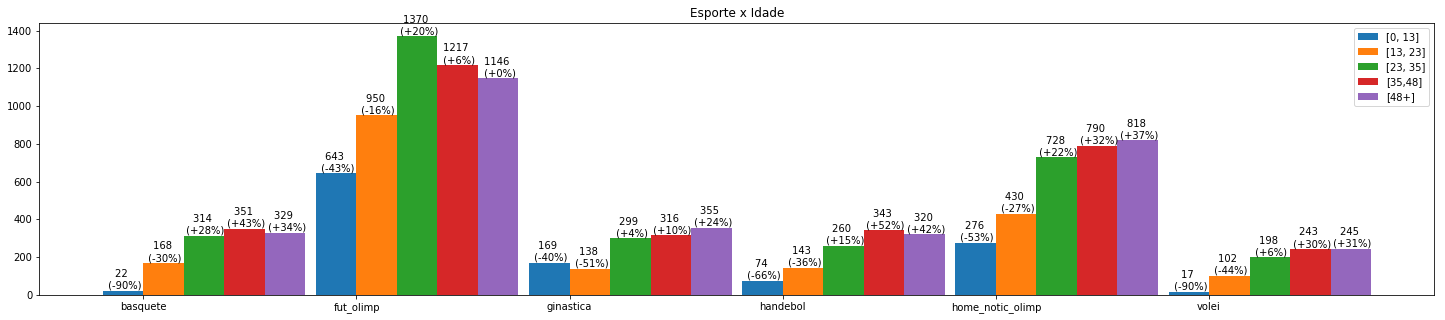

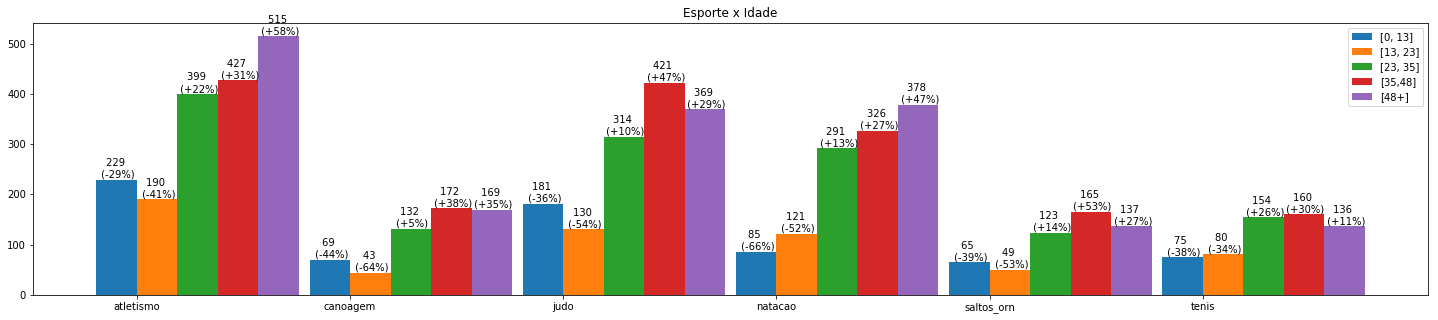

In [13]:
time_spent_in_olympics = data_frame[['home_notic_olimp', 'fut_olimp', 'ginastica', 'basquete', 'volei', 'handebol']].mean()
bar_chart = MultipleColumnsBarChartByClass.MultipleColumnsBarChartByClass(plt, data_frame=idade_without_null, rows=1, columns=1, x_size=25, y_size=5)

bar_chart.set_attribute_values(['home_notic_olimp', 'fut_olimp', 'ginastica', 'basquete', 'volei', 'handebol']) \
         .set_class_values(idade_without_null.idade) \
         .plot_chart('Esporte x Idade', 0, 0, bar_width=0.19, column='idade', avg_values=time_spent_in_olympics)
        
time_spent_in_olympics = data_frame[['tenis', 'atletismo', 'judo', 'saltos_orn', 'canoagem', 'natacao']].mean()
bar_chart = MultipleColumnsBarChartByClass.MultipleColumnsBarChartByClass(plt, data_frame=idade_without_null, rows=1, columns=1, x_size=25, y_size=5)

bar_chart.set_attribute_values(['tenis', 'atletismo', 'judo', 'saltos_orn', 'canoagem', 'natacao']) \
         .set_class_values(idade_without_null.idade) \
         .plot_chart('Esporte x Idade', 0, 0, bar_width=0.19, column='idade', avg_values=time_spent_in_olympics) 

Podemos notar que o público mais jovem, com menos de 23 anos não demonstrou muito interesse nas olímpiadas quando comparado aos demais, os que acompanharam mais de perto as olímpiadas pelo globo esporte foi o público mais velho, com mais de 35 anos, já o grupo maior, o de 23 a 35 anos se interessou acima da média, mas não muito.

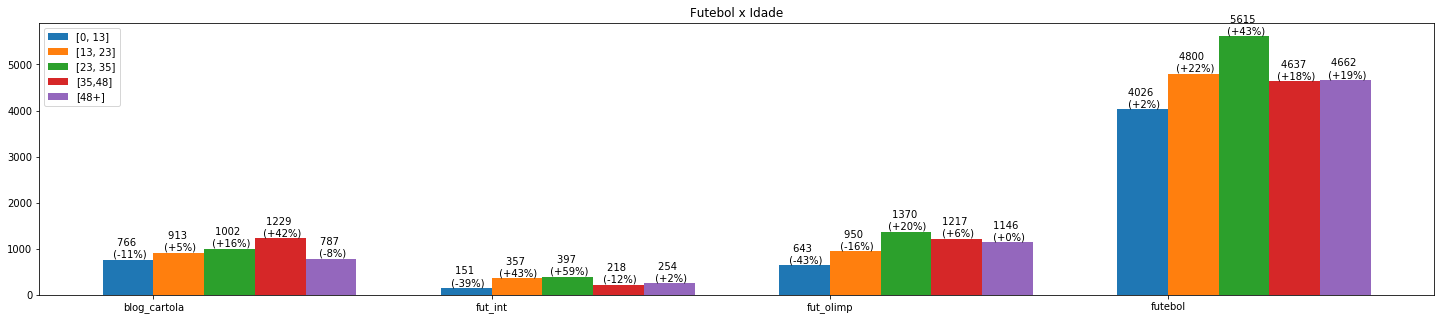

In [14]:
bar_chart = MultipleColumnsBarChartByClass.MultipleColumnsBarChartByClass(plt, data_frame=idade_without_null, rows=1, columns=1, x_size=25, y_size=5)

time_spent_in_soccer = data_frame[['fut_olimp', 'futebol', 'fut_int', 'blog_cartola']].mean()
bar_chart.set_attribute_values(['fut_olimp', 'futebol', 'fut_int', 'blog_cartola']) \
         .set_class_values(idade_without_null.idade) \
         .plot_chart('Futebol x Idade', 0, 0, bar_width=0.15, column='idade', avg_values=time_spent_in_soccer)

Aqui nós temos um fato interessante, pelos dados de idade serem esparsos, acabamos vendo que todas as idades se interessam acima da média por futebol nacional, o que não deveria ser assim, ou seja, existe algum outro fator, fora a idade que inflência nesse interesse.

Já para o futebol internacional podemos ver um interesse maior entre os usuários que tem de 13 a 35 anos, o interessante é que esse interesse do grupo 1 (13 a 23 anos) não se manifestou nas olímpiadas.

E sobre o acesso ao blog cartola, supredeentemente o grupo 3 é o que tem maior interesse, o que é interessante visto que mesmo no futebol nacional este grupo não teve um destaque tão grande.

#### Home

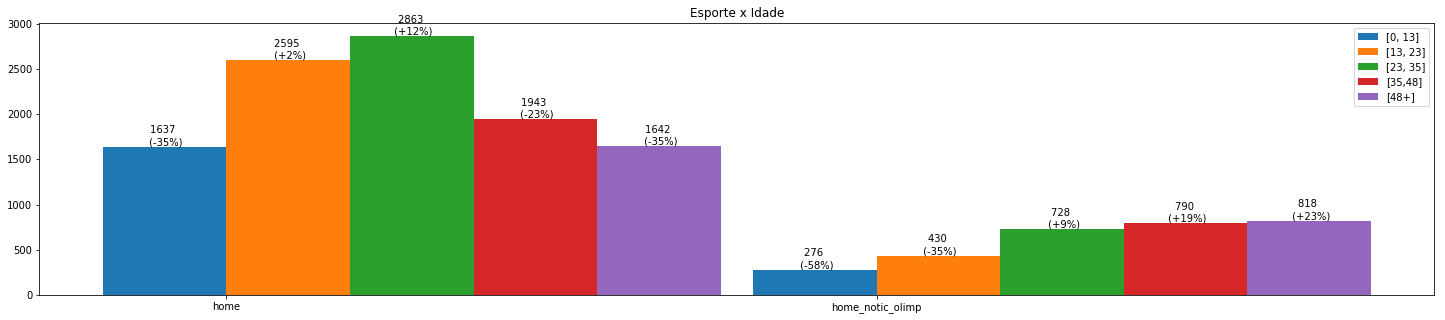

In [15]:
home_avgs = idade_without_null[['home', 'home_notic_olimp']].mean()
bar_chart = MultipleColumnsBarChartByClass.MultipleColumnsBarChartByClass(plt, data_frame=idade_without_null, rows=1, columns=1, x_size=25, y_size=5)

bar_chart.set_attribute_values(['home', 'home_notic_olimp']) \
         .set_class_values(idade_without_null.idade) \
         .plot_chart('Esporte x Idade', 0, 0, bar_width=0.19, column='idade', avg_values=home_avgs) 

Ao observar o uso da home observamos alguns pontos interessantes, a home normal, é mais utilizada pelo grupo 2. Porém nas olímpiadas as pessoas provavelmente acessaram mais a home, da olímpiada, para saber o status geral da competição, o que ocasionou o grupo 3 e 4 utilizarem mais esta página.

É importante frizar que em nenhum dos casos o grupo 1 utiliza a home com frequência, ou seja, eles vão direto para a notícia por outros meios, e seria interessante analisar como eles chegam até a notícia.

Sexo
-----

Aqui realizaremos os mesmos questionamentos realizados acima, porém agora com o foco no sexo do usuário, para ver se isto influencia de alguma forma no uso do globo esporte e como influencia.

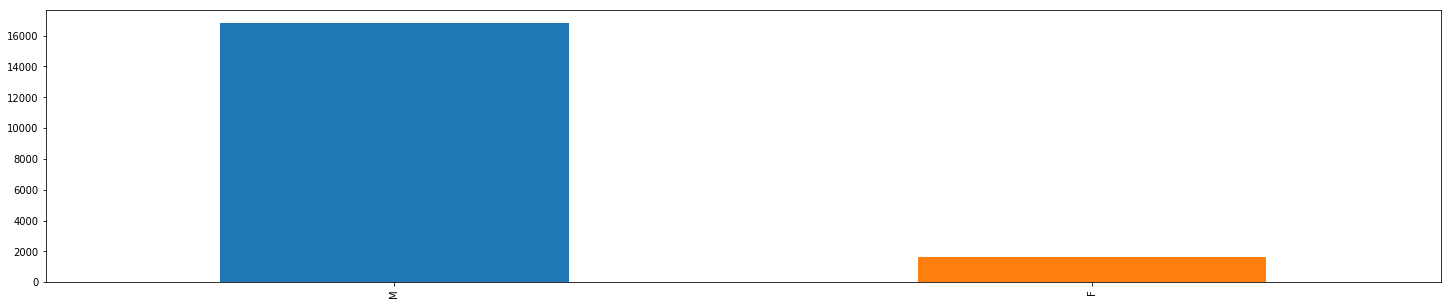

In [16]:
sex_without_null = data_frame.loc[data_frame['sexo'].notnull()]
sex_without_null['sexo'].value_counts().plot(kind='bar', figsize=(25, 5))

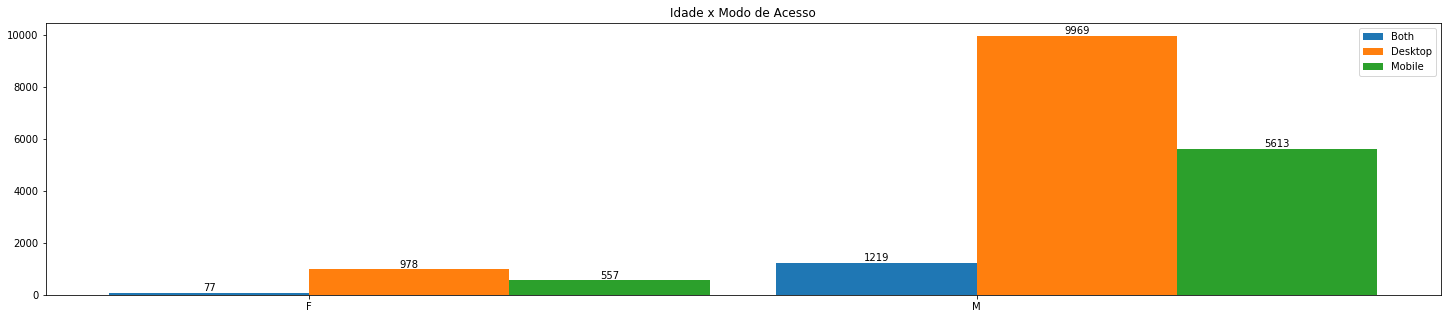

In [17]:
bar_chart = SingleColumnBarChartByClass.SingleColumnBarChartByClass(plt, rows=1, columns=1, x_size=25, y_size=5)

bar_chart.set_attribute_values(sex_without_null.sexo) \
         .set_class_values(sex_without_null.device_preference) \
         .plot_chart('Idade x Modo de Acesso', 0, 0)

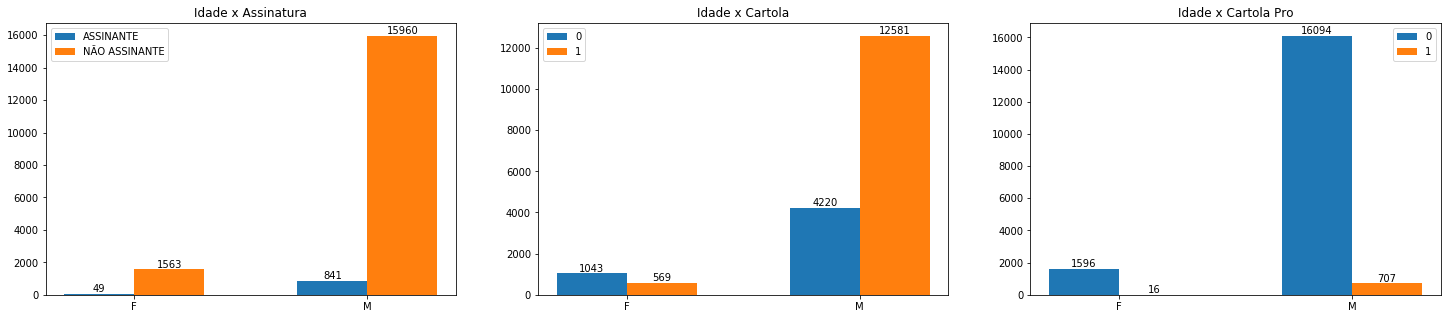

In [18]:
bar_chart = SingleColumnBarChartByClass.SingleColumnBarChartByClass(plt, rows=1, columns=3, x_size=25, y_size=5)

bar_chart.set_attribute_values(sex_without_null.sexo) \
         .set_class_values(sex_without_null.tipo) \
         .plot_chart('Idade x Assinatura', 0, 0)
        
bar_chart.set_attribute_values(sex_without_null.sexo) \
         .set_class_values(sex_without_null.cartola) \
         .plot_chart('Idade x Cartola', 0, 1)
        
bar_chart.set_attribute_values(sex_without_null.sexo) \
         .set_class_values(sex_without_null.cartola_pro) \
         .plot_chart('Idade x Cartola Pro', 0, 2)

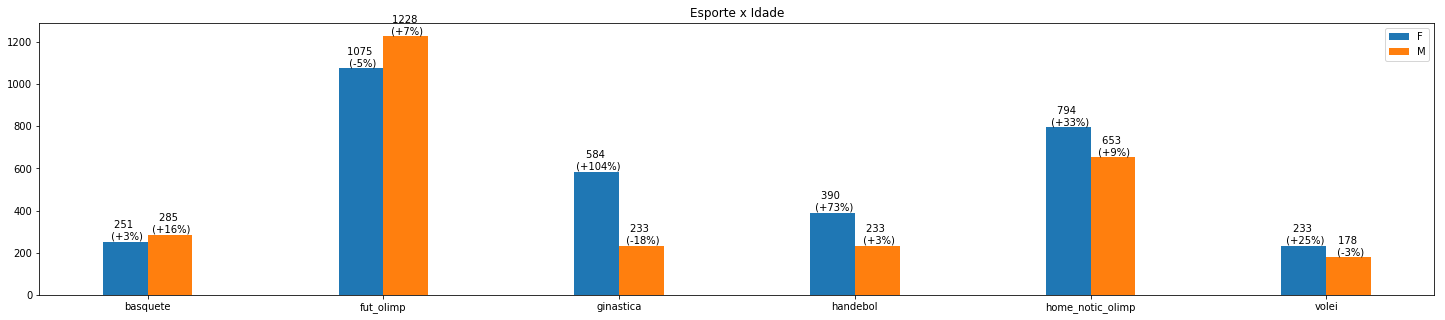

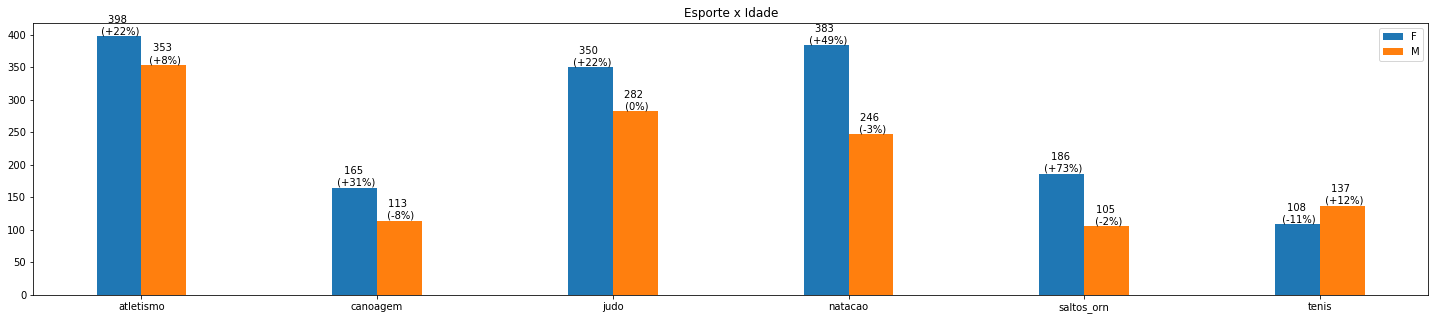

In [19]:
time_spent_in_olympics = data_frame[['home_notic_olimp', 'fut_olimp', 'ginastica', 'basquete', 'volei', 'handebol']].mean()
bar_chart = MultipleColumnsBarChartByClass.MultipleColumnsBarChartByClass(plt, data_frame=sex_without_null, rows=1, columns=1, x_size=25, y_size=5)

bar_chart.set_attribute_values(['home_notic_olimp', 'fut_olimp', 'ginastica', 'basquete', 'volei', 'handebol']) \
         .set_class_values(sex_without_null.sexo) \
         .plot_chart('Esporte x Idade', 0, 0, bar_width=0.19, column='sexo', avg_values=time_spent_in_olympics)
        
time_spent_in_olympics = data_frame[['tenis', 'atletismo', 'judo', 'saltos_orn', 'canoagem', 'natacao']].mean()
bar_chart = MultipleColumnsBarChartByClass.MultipleColumnsBarChartByClass(plt, data_frame=sex_without_null, rows=1, columns=1, x_size=25, y_size=5)

bar_chart.set_attribute_values(['tenis', 'atletismo', 'judo', 'saltos_orn', 'canoagem', 'natacao']) \
         .set_class_values(sex_without_null.sexo) \
         .plot_chart('Esporte x Idade', 0, 0, bar_width=0.19, column='sexo', avg_values=time_spent_in_olympics) 


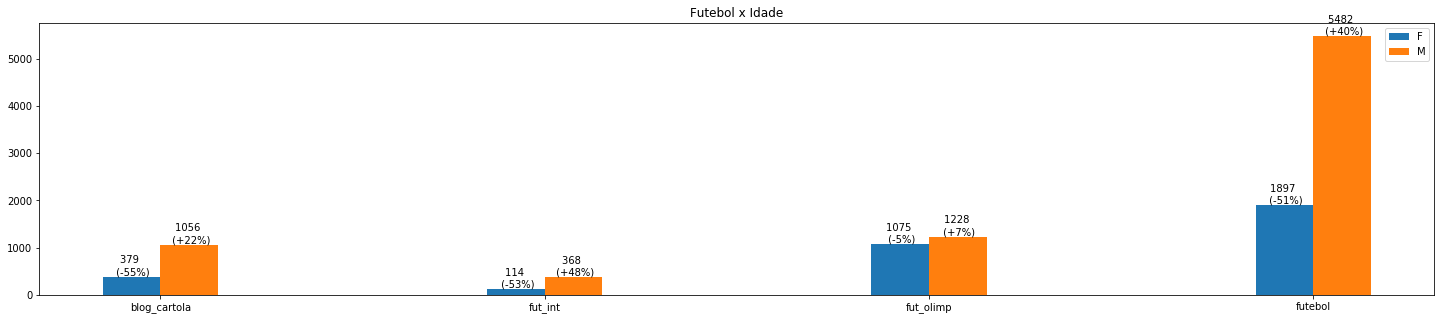

In [20]:
bar_chart = MultipleColumnsBarChartByClass.MultipleColumnsBarChartByClass(plt, data_frame=sex_without_null, rows=1, columns=1, x_size=25, y_size=5)

time_spent_in_soccer = data_frame[['fut_olimp', 'futebol', 'fut_int', 'blog_cartola']].mean()
bar_chart.set_attribute_values(['fut_olimp', 'futebol', 'fut_int', 'blog_cartola']) \
         .set_class_values(sex_without_null.sexo) \
         .plot_chart('Futebol x Idade', 0, 0, bar_width=0.15, column='sexo', avg_values=time_spent_in_soccer)

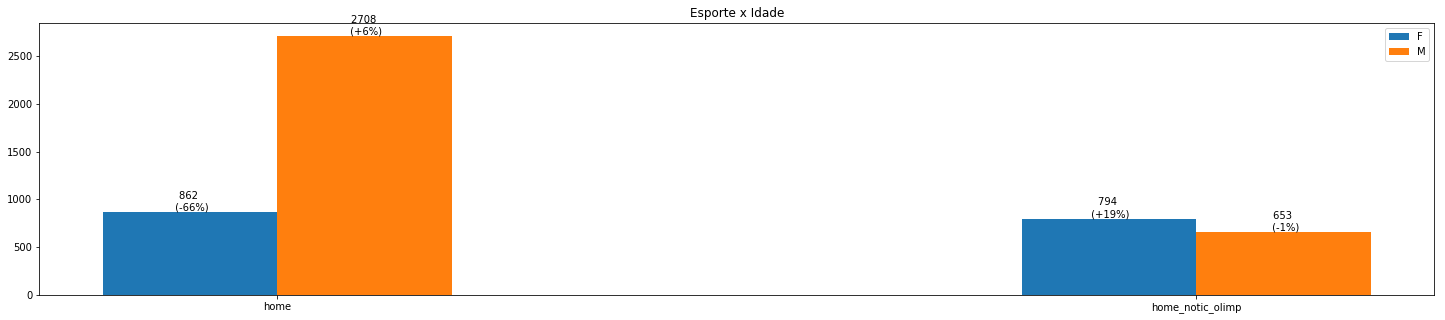

In [21]:
home_avgs = sex_without_null[['home', 'home_notic_olimp']].mean()
bar_chart = MultipleColumnsBarChartByClass.MultipleColumnsBarChartByClass(plt, data_frame=sex_without_null, rows=1, columns=1, x_size=25, y_size=5)

bar_chart.set_attribute_values(['home', 'home_notic_olimp']) \
         .set_class_values(sex_without_null.sexo) \
         .plot_chart('Esporte x Idade', 0, 0, bar_width=0.19, column='sexo', avg_values=home_avgs) 

UF
---

In [22]:
df_uf = data_frame

df_uf['regiao'] = df_uf['uf']

sudeste = ['Sao Paulo', 'Rio de Janeiro', 'Minas Gerais', 'Espirito Santo']
sul = ['Parana', 'Santa Catarina', 'Rio Grande do Sul']
nordeste = ['Alagoas', 'Bahia', 'Ceara', 'Maranhao', 'Paraiba', 'Pernambuco', 'Piaui', 'Rio Grande do Norte',
                    'Sergipe']
norte = ['Amapa', 'Roraima', 'Amazonas', 'Rondonia', 'Tocantins', 'Para', 'Acre']
centro_oeste = ['Distrito Federal', 'Goias', 'Mato Grosso', 'Mato Grosso do Sul']

df_uf.loc[df_uf['regiao'].isin(sudeste), 'regiao'] = 'sudeste'
df_uf.loc[df_uf['regiao'].isin(sul), 'regiao'] = 'sul'
df_uf.loc[df_uf['regiao'].isin(nordeste), 'regiao'] = 'nordeste'
df_uf.loc[df_uf['regiao'].isin(norte), 'regiao'] = 'norte'
df_uf.loc[df_uf['regiao'].isin(centro_oeste), 'regiao'] = 'centrooeste'

df_uf = df_uf.loc[df_uf['regiao'].notnull()]

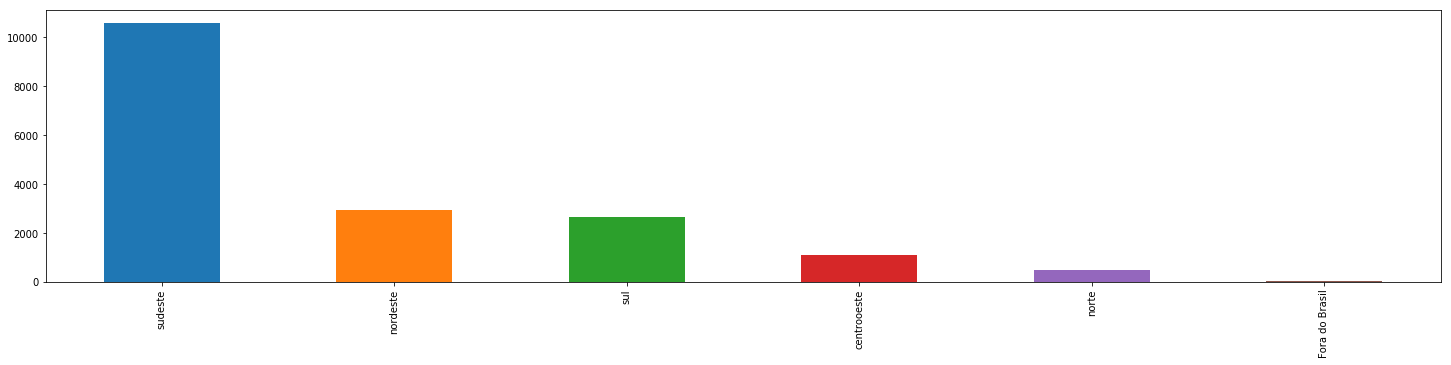

In [23]:
df_uf['regiao'].value_counts().plot(kind='bar', figsize=(25, 5))

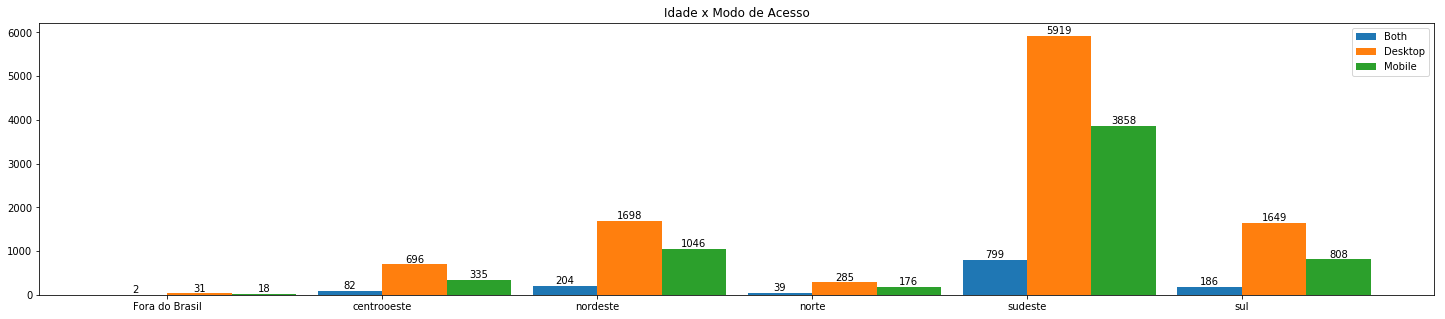

In [24]:
plt.figure()
bar_chart = SingleColumnBarChartByClass.SingleColumnBarChartByClass(plt, rows=1, columns=1, x_size=25, y_size=5)

bar_chart.set_attribute_values(df_uf.regiao) \
         .set_class_values(df_uf.device_preference) \
         .plot_chart('Idade x Modo de Acesso', 0, 0)

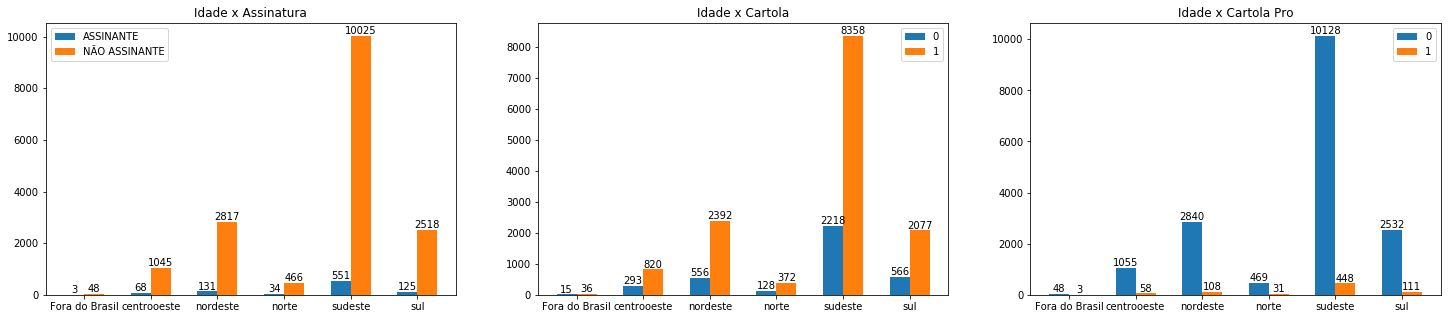

In [25]:
bar_chart = SingleColumnBarChartByClass.SingleColumnBarChartByClass(plt, rows=1, columns=3, x_size=25, y_size=5)

bar_chart.set_attribute_values(df_uf.regiao) \
         .set_class_values(df_uf.tipo) \
         .plot_chart('Idade x Assinatura', 0, 0)
        
bar_chart.set_attribute_values(df_uf.regiao) \
         .set_class_values(df_uf.cartola) \
         .plot_chart('Idade x Cartola', 0, 1)
        
bar_chart.set_attribute_values(df_uf.regiao) \
         .set_class_values(df_uf.cartola_pro) \
         .plot_chart('Idade x Cartola Pro', 0, 2)

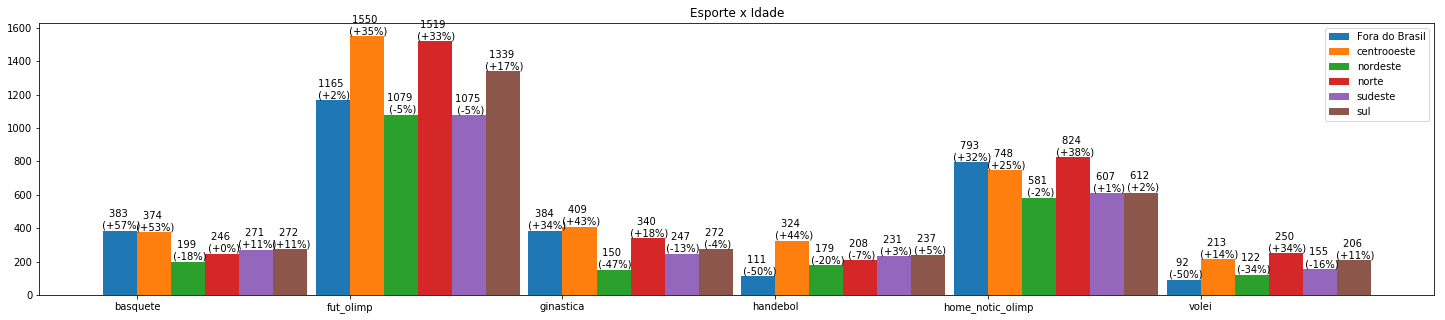

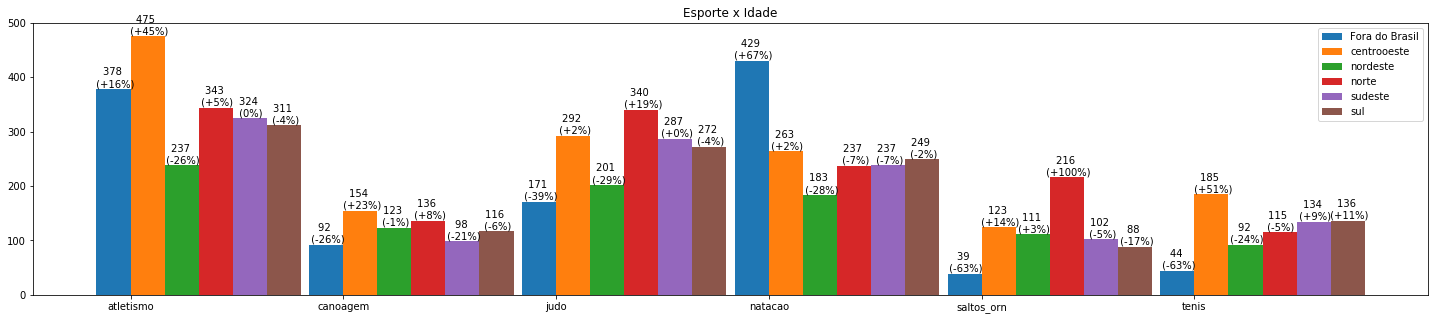

In [30]:
time_spent_in_olympics = data_frame[['home_notic_olimp', 'fut_olimp', 'ginastica', 'basquete', 'volei', 'handebol']].mean()
bar_chart = MultipleColumnsBarChartByClass.MultipleColumnsBarChartByClass(plt, data_frame=df_uf, rows=1, columns=1, x_size=25, y_size=5)

bar_chart.set_attribute_values(['home_notic_olimp', 'fut_olimp', 'ginastica', 'basquete', 'volei', 'handebol']) \
         .set_class_values(df_uf.regiao) \
         .plot_chart('Esporte x Idade', 0, 0, bar_width=0.16, column='regiao', avg_values=time_spent_in_olympics)
        
time_spent_in_olympics = data_frame[['tenis', 'atletismo', 'judo', 'saltos_orn', 'canoagem', 'natacao']].mean()
bar_chart = MultipleColumnsBarChartByClass.MultipleColumnsBarChartByClass(plt, data_frame=df_uf, rows=1, columns=1, x_size=25, y_size=5)

bar_chart.set_attribute_values(['tenis', 'atletismo', 'judo', 'saltos_orn', 'canoagem', 'natacao']) \
         .set_class_values(df_uf.regiao) \
         .plot_chart('Esporte x Idade', 0, 0, bar_width=0.16, column='regiao', avg_values=time_spent_in_olympics) 

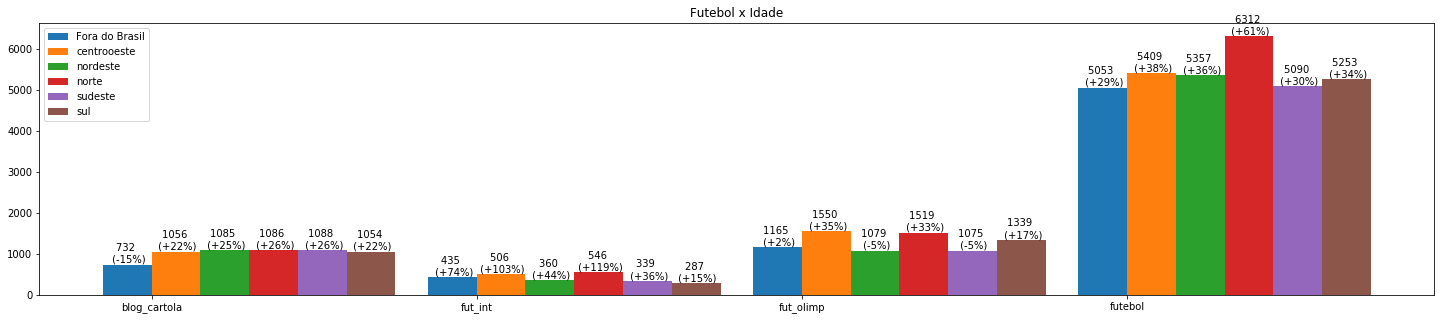

In [27]:
bar_chart = MultipleColumnsBarChartByClass.MultipleColumnsBarChartByClass(plt, data_frame=df_uf, rows=1, columns=1, x_size=25, y_size=5)

time_spent_in_soccer = data_frame[['fut_olimp', 'futebol', 'fut_int', 'blog_cartola']].mean()
bar_chart.set_attribute_values(['fut_olimp', 'futebol', 'fut_int', 'blog_cartola']) \
         .set_class_values(df_uf.regiao) \
         .plot_chart('Futebol x Idade', 0, 0, bar_width=0.15, column='regiao', avg_values=time_spent_in_soccer)